# Uninterrupted character-level input with token representation using GNN

Ideas:<br>
 - Continuous unpadded/untruncated character sequences
 - Generate graph after token representation inside model
 - Using dynamic sparse GNN

Test Results:
| metric | test 1 | test 2 | test 3 | test 4 | test 5 | Average |
|:---|:--:|:--:|:--:|:--:|:--:|:--:|
| f1-score | 
| accuracy | 
| precision |
| recall | 
| loss | 

## Import Packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from copy import copy
import spacy
from umap import UMAP

import os
import PyPDF2
from bs4 import BeautifulSoup
import textract
import json
import gzip
import re
import collections
import csv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
device

device(type='cuda')

## Data Classes and Functions

In [3]:
model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = BertTokenizer.from_pretrained(model)
# tokenizer = TweetTokenizer()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [4]:
with open(r'data\reduced_embeddings\reduced_bert_emb_1.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(list(tokenizer.vocab.keys()), embeddings))
len(token_vocab_dict)

119547

In [5]:
folder_path = r'data\CrawledWeb\TopicClassification\HTMLClassification\htmls'
urls_df = pd.read_csv(r'data\CrawledWeb\TopicClassification\URLClassification\url_classes2.csv')
# df = pd.DataFrame(index=urls_df.index,columns=['file_name', 'content'])

In [68]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' \t'
all_chars = set(allowed_chars)

In [69]:
# chars_to_replace = string.punctuation + ' \n\t'
# def remove_residuals(s):
#     for i in range(2):
#         s = re.sub(r'([' + chars_to_replace + '])[' + chars_to_replace + ']*', r'\1', s)
#         s = re.sub(r'([{}])\1+'.format(re.escape(string.punctuation + ' ')), r'\1', s)
#         s = re.sub(f'[^{re.escape(allowed_chars)}]', ' ', s)
#         s = re.sub(r'([0-9!\"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~ \t\n\r]{9,})', '', s)
#         s = re.sub( r'([a-zA-Z])\1{3,}', r'\1', s)
#         s = re.sub(r'((\b\w{1,2}\b) ){4,}', '', s)
        
#     tokenized_doc = tokenizer.tokenize(s)
#     s = ' '.join([t for t in tokenized_doc if t in token_vocab_dict])
#     s = re.sub(r'([{}])\1+'.format(re.escape(string.punctuation + ' ')), r'\1', s)
#     s = re.sub(f'[^{re.escape(allowed_chars)}]', ' ', s)
#     s = re.sub(r'([0-9!\"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~ \t\n\r]{9,})', '', s)
#     s = re.sub( r'([a-zA-Z])\1{3,}', r'\1', s)
#     s = re.sub(r'\s(.\s){3,}', ' ', s)
        
#     return s

# with gzip.open(rf'data\CrawledWeb\TopicClassification\URLClassification\id_content.json.gz', 'rt') as file:
#     web_contents = json.load(file)

# doc_lengths = np.array([len(web_contents[i]) for i in web_contents])
# web_contents = {int(k): remove_residuals(v) for k, v in web_contents.items()}
    
# with gzip.open(rf'data\CrawledWeb\TopicClassification\URLClassification\id_content6.json.gz', 'wt') as file:
#     json.dump(web_contents, file)

In [6]:
from pattern.en import parse

text = "Mynameisfardin,howcanIregisterhere?"
print(parse(text, tokenize=True).split())


ModuleNotFoundError: No module named 'pattern'

In [159]:
with gzip.open(rf'data\CrawledWeb\TopicClassification\URLClassification\id_content6.json.gz', 'rt') as file:
    web_contents = json.load(file)
web_contents = {int(k): v for k, v in web_contents.items()}
doc_lengths = np.array([len(web_contents[i]) for i in web_contents])

In [160]:
web_contents[10][:1000]

'b #s - no - s #cro #ll { over #flow : hidden } j #s - barco #de - s #can #ner _ w #rap #per { position : fixed ; heightwidthtop left bottom right indexj #s - barco #de - s #can #ner _ w #rap #per barco #de - s #can #ner { heightwidthj #s - barco #de - s #can #ner _ w #rap #per barco #de - s #can #ner - off - screen - left { animation - name : slide #L #ef #t ; animation - duration : 5 #s ; animation - tim #ing - function : ea #se ; margin - left #s - barco #de - s #can #ner _ w #rap #per barco #de - s #can #ner - off - screen - up { animation - name : slide #U #p ; animation - duration : 75 #s ; animation - tim #ing - function : ea #se ; bottom : 10 % j #s - barco #de - s #can #ner _ w #rap #per barco #de - s #can #ner - off - screen - down { animation - name : slide #D #own ; animation - duration : 75 #s ; animation - tim #ing - function : ea #se ; bottom : 20 % key #fram #es slide #L #ef #t margin - left #mar #gin - left key #fram #es slide #U #p bottombottom : 10 % j #s - barco #de

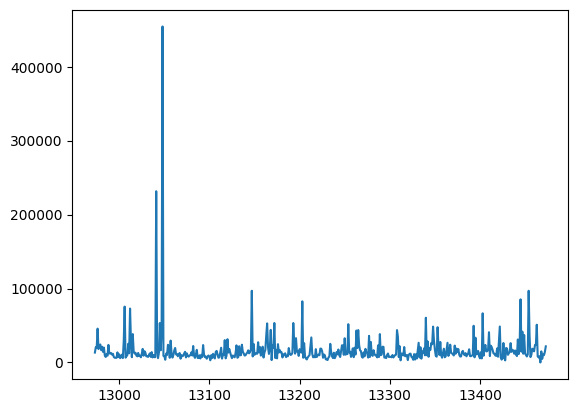

In [70]:
plt.plot(list(web_contents.keys())[12000:12500], doc_lengths[12000:12500])
plt.show()

In [10]:
active_indices = np.array(list(web_contents.keys()), dtype=np.int32)
df = pd.read_csv(r'data\CrawledWeb\TopicClassification\URLClassification\url_classes2.csv')
df = df.iloc[active_indices]
train_indices, val_indices = train_test_split(active_indices, test_size=0.1)

In [11]:
# for i in web_contents:
#     doc = tokenizer.tokenize(web_contents[i])
#     for t in doc:
#         if t not in token_vocab_dict:
#             token_vocab_dict[t] = torch.ones((64, ), dtype=torch.float32)
# # token_vocab_dict['\x01'] = torch.zeros((64, ), dtype=torch.float32)

In [12]:
# print(i)

In [13]:
print(np.max(doc_lengths))
print(list(web_contents.keys())[np.argmax(doc_lengths)])

5044695
27473


In [71]:
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}

In [72]:
# chars = set([c for i in web_contents for c in ' '.join([t.text for t in nlp(web_contents[i])])])
# allowed_chars = string.ascii_letters + string.digits + string.punctuation
# all_chars
# chars = set([c for t in token_vocab_dict for c in t])
vocab_dict = {c:i for i, c in enumerate(allowed_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
len(char_Set)

97

In [49]:
sample_text = 'this is a @#@ text �� ��@@�끠╦玆所n from� ^��, so take it!'
sample_tokens1 = tokenizer.tokenize(sample_text)
sample_tokens2 = [t for t in sample_tokens1 if set(t).issubset(char_Set)]
sample_tokens3 = tokenizer.tokenize(''.join(c for c in sample_text if c in char_Set))
sample_tokens4 = [t for t in sample_tokens3 if set(t).issubset(char_Set)]
print(' '.join(sample_tokens1))
print(' '.join(sample_tokens2))
print(' '.join(sample_tokens3))
print(' '.join(sample_tokens4))

this is a @ # @ text @ @ [UNK] [UNK] 所 n from ^ , so take it !
this is a @ # @ text @ @ [UNK] [UNK] n from ^ , so take it !
this ##isa @ # @ text @ @ n ##fr ##om ^ , sota ##keit !
this ##isa @ # @ text @ @ n ##fr ##om ^ , sota ##keit !


In [84]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, indices, num_classes, char_dict, token_dict, tokenizer, max_token_length=10000) -> None:
        super().__init__()
        y = y[indices].values
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        
        self.all_data = []# torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        # self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        self.token_lengths = []
        
        self.token_embeddign_ids = []
        for i in indices:
            doc=X[i][:max_token_length]
            
            tokens = tokenizer(''.join(c for c in doc if c in self.char_Set))
            tokens = [t for t in tokens]
            tokens.append('\x01')
            token_embs = [token_dict[t] if t in token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            doc = ' '.join(tokens)
            
            # for t in set(doc):
            #     self.char_dict.setdefault(t, len(self.char_dict))

            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            # char_pad_size = max(self.doc_char_length - len(indices), 0)
            # indices = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
            # token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            
            # self.token_embeddign_ids.append(token_embs)
            g_data = Data(x=characters,
                          character_length = len(characters),
                          num_tokens = len(token_lengths),
                          token_indices=token_indices,
                          token_lengths=token_lengths,
                          token_embeddings=token_embs)
            
                        #   character_token_lengths = torch.repeat_interleave(token_lengths, token_lengths)
            
            self.all_data.append(g_data)
            # self.token_lengths.append(token_lengths)
        
        
    def __getitem__(self, index):
        # emb_data = Data(x=self.token_embeddigns[self.token_embeddign_ids[index]])
        return self.all_data[index], self.y[index]#, Batch.from_data_list([emb_data])
        
    def __len__(self):
        return len(self.y)
        

In [85]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

# from scripts.data.datasets.GraphConstructorDataset3 import WordGraphLabeledDataset


class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


## Prepare Data

In [153]:
print(f'all: {len(doc_lengths)}')
print(f'over 20000: {len(np.argwhere(doc_lengths>20000))}')
print(np.squeeze(np.argwhere(doc_lengths>20000)))

all: 33257
over 20000: 10257
[    6     9    10 ... 33250 33253 33254]


In [145]:
len(web_contents[10])

118501

In [154]:
tokens = tokenizer.tokenize(web_contents[10])

In [155]:
ttokenizer = TweetTokenizer()
ttokens = ttokenizer.tokenize(web_contents[10])

In [156]:
wtokens = word_tokenize(web_contents[10])

In [158]:
tokens[:1000]

['b',
 '#',
 's',
 '-',
 'no',
 '-',
 's',
 '#',
 'c',
 '##ro',
 '#',
 'll',
 '{',
 'over',
 '#',
 'flow',
 ':',
 'hidden',
 '}',
 'j',
 '#',
 's',
 '-',
 'barco',
 '#',
 'de',
 '-',
 's',
 '#',
 'can',
 '#',
 'ner',
 '_',
 'w',
 '#',
 'rap',
 '#',
 'per',
 '{',
 'position',
 ':',
 'fixed',
 ';',
 'height',
 '##wid',
 '##th',
 '##top',
 'left',
 'bottom',
 'right',
 'index',
 '##j',
 '#',
 's',
 '-',
 'barco',
 '#',
 'de',
 '-',
 's',
 '#',
 'can',
 '#',
 'ner',
 '_',
 'w',
 '#',
 'rap',
 '#',
 'per',
 'barco',
 '#',
 'de',
 '-',
 's',
 '#',
 'can',
 '#',
 'ner',
 '{',
 'height',
 '##wid',
 '##th',
 '##j',
 '#',
 's',
 '-',
 'barco',
 '#',
 'de',
 '-',
 's',
 '#',
 'can',
 '#',
 'ner',
 '_',
 'w',
 '#',
 'rap',
 '#',
 'per',
 'barco',
 '#',
 'de',
 '-',
 's',
 '#',
 'can',
 '#',
 'ner',
 '-',
 'off',
 '-',
 'screen',
 '-',
 'left',
 '{',
 'animation',
 '-',
 'name',
 ':',
 'slide',
 '#',
 'L',
 '#',
 'ef',
 '#',
 't',
 ';',
 'animation',
 '-',
 'duration',
 ':',
 '5',
 '#',
 's',
 ';',

In [157]:
print(f'bert tokens: {len(tokens)}')
print(f'tweet tokens: {len(ttokens)}')
print(f'wtokens: {len(wtokens)}')

bert tokens: 43714
tweet tokens: 35602
wtokens: 41545


In [86]:
batch_size = 4

In [87]:
train_dataset = CharacterandTokenLevelCustomDataset(web_contents, df.Topic, train_indices, len(class_id), vocab_dict, token_vocab_dict, tokenizer.tokenize, max_token_length=32768)
test_dataset = CharacterandTokenLevelCustomDataset(web_contents, df.Topic, val_indices, len(class_id), vocab_dict, token_vocab_dict, tokenizer.tokenize, max_token_length=32768)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [88]:
num_embedding = len(vocab_dict)
# del web_contents
# del train_indices
# del vocab_dict
# del token_vocab_dict
# del val_indices
# del df
# del active_indices
# del doc_lengths
# del embeddings

In [89]:
# batch_size = 16
# train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
# test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [90]:
# X,y = next(iter(test_dataset))
# print(f'X.character_length: {X.character_length}')
# print(f'X.num_tokens: {X.num_tokens}')
# print(f'X.token_indices: {X.token_indices}')
# print(f'len(X.token_indices): {len(X.token_indices)}')
# print(f'sum(X.token_lengths): {sum(X.token_lengths)}')
# print(f'X.token_embeddings.shape: {X.token_embeddings.shape}')

In [91]:
X, y = next(iter(test_dataloader))

In [92]:
x_shapes = []
for X, y in test_dataloader:
    x_shapes.append(X.x.shape[0])

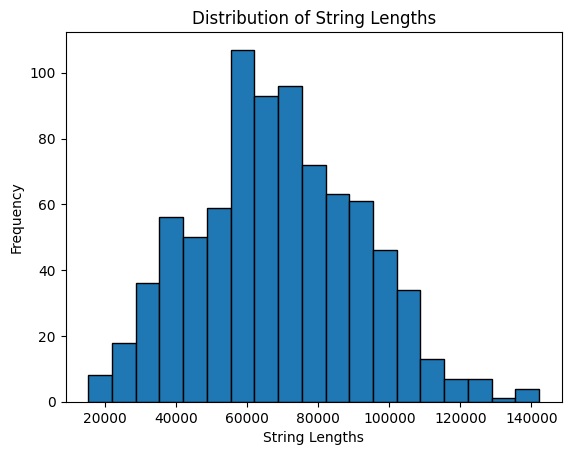

In [93]:
# Create a histogram
plt.hist(x_shapes, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('String Lengths')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')

# Show the chart
plt.show()

In [94]:
X

DataBatch(x=[47405], character_length=[4], num_tokens=[4], token_indices=[47405], token_lengths=[11263], token_embeddings=[11263, 64], batch=[47405], ptr=[5], cumulative_token_indices=[47405])

## Model Classes and Functions

In [95]:
# token_reps = scatter_mean(X.x, X.cumulative_token_indices)

In [96]:
class AdaptiveScatterPooling(nn.Module):

    def __init__(self, num_features=128, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.epsilon = nn.Parameter(torch.randn((num_features,1, 1)))
        
    def forward(self, x, index):
        sc_max = scatter_max(x, index, dim=1)[0]
        sc_mean = scatter_mean(x, index, dim=1)
        return sc_mean +  + (sc_max-sc_mean) * self.epsilon


In [97]:
# base_range = torch.arange(1000000, device=device)
# for i in range(50000):
#     rr = base_range[:50000]
    # rr = torch.arange(50000, device=device)

In [98]:
from torch_geometric.nn import GATv2Conv, SimpleConv


class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        # self.hidden_dim = hidden_dim
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4)
        # self.gnn = SimpleConv(aggr='mean')
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        # self.out_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        # self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        # self.bn4 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, graph, total_token_count, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, graph.edge_index, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x[:total_token_count].T).T)#self.bn2(self.conv(x[:total_token_count].T).T))
        x3 =  F.leaky_relu_(self.bn3(self.fc(x1[total_token_count:])))
        x1 = F.leaky_relu_(self.bn1(x1[:total_token_count]))
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=0)
        # x = self.bn4(x)
        return x, edge_weights #F.leaky_relu_(self.bn4(self.out_fc(x)))

In [99]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(0, lattice_links.shape[1]*2, step=2):
        #     edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i].view(1,-1), tc_range], dim=0)
        #     edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
        # for i in range(lattice_links.shape[1]*2, lattice_links.shape[1]*2+random_links.shape[1]):
        #     edge_index[:, i*random_links.shape[0]:(i+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance):
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_coutns, (total_token_coutns, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = torch.arange(lattice_start_distance, self.lattice_step*lattice_edges+1, self.lattice_step, device=x.device).view(1, -1)

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [100]:
# torch.max(X.x)

In [101]:
# embedding = nn.Embedding(len(vocab_dict), 64)
# x = embedding(X.x)
# x = scatter_mean(x.T, X.cumulative_token_indices, dim=1)

# graph_generator = GenGraph(64, 1, 2)
# graph = graph_generator.gen_graph(x.T, len(X.token_lengths), X.num_tokens, 2, 2)
# gcnn1 = GCNN(64)
# x, edge_weights = gcnn1(graph.x, graph, len(X.token_lengths), return_attention_weights = True)
# edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
# # edge_weights = torch.sum(edge_weights[1][:graph.edge_index.shape[1], :],dim=1)
# graph = graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(X.token_lengths), X.num_tokens, 4, 4, p_keep=2, lattice_start_distance=3)
# graph

In [102]:
# weights.T[0].view(-1, len(X.token_lengths))

In [103]:
# r_v = torch.randn(5, 6)
# torch.topk(r_v, 2, dim=0)
# r_v
# len(graph.x)
# edge_weights.view(-1, len(X.token_lengths))
# important_indices = torch.topk(weights.T[0][:-1*len(X.token_lengths)].view(-1, len(X.token_lengths)), 1, dim=0).indices.squeeze()
# print(important_indices)
# print(torch.arange(important_indices.shape[0]) + important_indices*important_indices.shape[0])

In [104]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, token_emb_dim=64, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_char_count = max_char_count
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.token_emb_dim = token_emb_dim
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)

        # self.conv5 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim + self.token_emb_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 32
        self.fc0 =  nn.Linear(hidden_dim , hidden_dim + self.token_emb_dim)
        self.fc1 = nn.Linear(hidden_dim + self.token_emb_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        # self.fc3 = nn.Linear(hidden_dim * k, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, g_data):
        # rand_edges = self.get_random_edge_count(g_data.x.shape[0])
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2], dim=0)

        x = F.relu(self.conv3(x)) 
        
        # x = self.dropout(x)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        graph = self.graph_generator.gen_graph(x.T, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1 # max(1, rand_edges-1)
        lattice_edges = lattice_edges-1 # max(1, lattice_edges-1)
        # self.gen_graph(x.T, len(g_data.token_lengths), g_data.num_tokens)
        # x = torch.cat([graph.x, g_data.token_embeddings], dim=1)
        
        x, edge_weights = self.gcnn1(graph.x, graph, len(g_data.token_lengths), return_attention_weights = True)
        # edge_weights = torch.sum(edge_weights[1][:graph.edge_index.shape[1], :],dim=1)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        # x = x + graph.x  /////
        # graph = self.graph_generator.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)    //////
        #self.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)
        x, edge_weights = self.gcnn2(x, graph, len(g_data.token_lengths))
        # x = x + x1  /////
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

    # def get_random_edge_count(self, input_char_count):
    #     if input_char_count>390000:
    #         print(f'input_char_count: {input_char_count}')
    #         return 1
    #     if input_char_count>300000:
    #         return 2
    #     if input_char_count>250000:
    #         return 3
    #     return 4

In [105]:
model = CNN_for_Text(num_embedding=num_embedding, batch_size=batch_size, max_char_count=256, embedding_dim=128, hidden_dim=64, num_out_features=len(class_id), random_edges=4, lattice_edges=4, virtual_nodes=0) #.to(device)
print(summary(model, X.cpu()))
# del model

+-------------------------------------------+------------------------------+----------------+----------+
| Layer                                     | Input Shape                  | Output Shape   | #Param   |
|-------------------------------------------+------------------------------+----------------+----------|
| CNN_for_Text                              | [47405, 47405]               | [4, 12]        | 577,676  |
| ├─(embedding)Embedding                    | [47405]                      | [47405, 128]   | 12,416   |
| ├─(conv1)Conv1d                           | [128, 47405]                 | [64, 47405]    | 41,024   |
| ├─(pool1)MaxPool1d                        | --                           | --             | --       |
| ├─(conv2)Conv1d                           | [64, 47405]                  | [64, 47405]    | 20,544   |
| ├─(conv3)Conv1d                           | [128, 11263]                 | [64, 11263]    | 24,640   |
| ├─(conv4)Conv1d                           | --       

In [106]:
# model = model.eval()
# with torch.no_grad():
#     model(X.cpu()).shape #.to(device)
torch.cuda.empty_cache()

In [107]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [108]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix


def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


## Test Model

In [121]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [110]:
import os
print(os.getcwd())

c:\Users\fardin\Projects\Form&ColorIntelligence


In [111]:
# from scripts.managers.ClassifierModelManager import ClassifierModelManager
from lightning.pytorch.loggers import CSVLogger
import lightning as L
# from scripts.managers.ClassifierModelManager import ClassifierModelManager

In [112]:
# classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=3, lattice_step=2, virtual_nodes=0).to(device)
# optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=0.0032, weight_decay=0.000012)
# # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80],gamma=0.5, verbose=False)
# loss_func = torch.nn.BCEWithLogitsLoss()
# classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
#                                                     num_classes=len(class_id),
#                                             learning_rate=0.0032,
#                                             batch_size=batch_size,
#                                             optimizer=optimizer,
#                                             loss_func=loss_func,
#                                             lr_scheduler=lr_scheduler,
#                                             user_lr_scheduler=True
#                                             ).to(device)


# model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN2',device=device, num_train_epoch=400)
# # trainer = L.Trainer(
# #             # callbacks=callbacks,
# #             max_epochs=epochs,
# #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
# #             logger=CSVLogger(save_dir='logs/', name='log2'), 
# #             num_sanity_val_steps=0,
# #         #     default_root_dir='models\model2_word_embedding-256-2'
# #         )

# # model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
# # model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}')
# # model_manager.torch_model = model_manager.torch_model.to(device)
# # model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}',True, True, True, True, True, True, True, multi_class=True)
# # # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
# # classfier_lightning_model.model = classfier_lightning_model.model.eval()
# # classfier_lightning_model = classfier_lightning_model.eval()
# # calculate_metrics(classfier_lightning_model, test_dataloader)
# # return model_manager\
# model_manager.draw_summary(test_dataloader)
# # print(summary(model_manager, X.to(device)))

In [113]:
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(model_manager.trainer)
# tuning_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=0.00001,max_lr=0.01, num_training=100)

# fig = tuning_result.plot(suggest=True)
# fig.show()

In [114]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, min_lr=min_lr,max_lr=max_lr)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [122]:
# Fardin Rastakhiz @ 2023
import torch
from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                if(give_hinge_loss):
                    print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [123]:

# for i in range(10):
def train_model(epochs=30, dropout=0.2, weight_decay=0.00001, lr=0.0002):
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40, 50, 60, 80, 80, 90],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN8_HTML_Spacy',device=device, num_train_epoch=epochs, accumulate_grad_batches=128)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'spacy_embedding_tests_{dropout}_{weight_decay}_{lr}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [124]:
# torch.cuda.empty_cache()

In [125]:
# import gc
# gc.collect()

In [126]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 550 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.204     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([3324, 12])
torch.Size([3324, 12])
torch.Size([3324])
torch.Size([3324])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

classification report: 
               precision    recall  f1-score   support

           0     0.3148    0.0607    0.1018       280
           1     0.0000    0.0000    0.0000       295
           2     0.0000    0.0000    0.0000       279
           3     0.0000    0.0000    0.0000       274
           4     0.0000    0.0000    0.0000       301
           5     0.0773    0.0606    0.0679       264
           6     0.1200    0.0213    0.0361       282
           7     0.0949    0.9727    0.1729       293
           8     0.0000    0.0000    0.0000       296
           9     0.0000    0.0000    0.0000       279
          10     0.0000    0.0000    0.0000       294
          11     0.0000    0.0000    0.0000       187

    accuracy                         0.0975      3324
   macro avg     0.0506    0.0929    0.0316      3324
weighted avg     0.0512    0.0975    0.0323      3324

confusion matrix:
 tensor([[ 17,   0,   2,   0,   0,  30,   6, 223,   2,   0,   0,   0],
        [  5,   0, 

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([3324, 12])
torch.Size([3324, 12])
torch.Size([3324])
torch.Size([3324])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

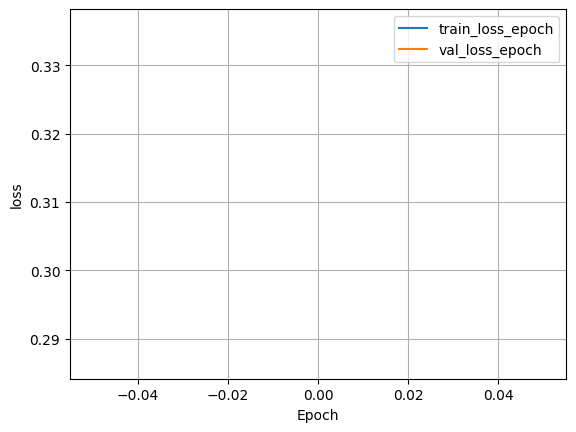

In [127]:
# for i in range(5):
model_mgr = train_model(130, 0.2, 0.000012, 0.0035)

In [ ]:
model_mgr.trainer.checkpoint_callback.best_model_path

'logs/CNN-GNN5\\version_22\\checkpoints\\epoch=1-step=4.ckpt'

In [ ]:
# dropouts = [0.2]
# start_lrs = [0.0035, 0.0037, 0.0039]
# wds = [0.000012]#, 0.000013, 0.0000125]
# for dp in dropouts:
#     for lr in start_lrs:
#         for wd in wds:
#             model_mgr = train_model(100, dp, wd, lr)

In [ ]:
# classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.176, num_out_features=len(class_id), seed=911, g_node_degree=25, virtual_nodes=1).to(device)
# optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
# loss_func = torch.nn.BCEWithLogitsLoss()
# classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
#                                                     num_classes=len(class_id),
#                                             learning_rate=lr,
#                                             batch_size=batch_size,
#                                             optimizer=optimizer,
#                                             loss_func=loss_func,
#                                             lr_scheduler=lr_scheduler,
#                                             user_lr_scheduler=True
#                                             ).to(device)

# trainer = L.Trainer(
#             max_epochs=50,
#             accelerator='gpu',
#         #     logger=self.logger,
#             num_sanity_val_steps=0,
#         #     default_root_dir=self.model_save_dir
#         )
# # model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN',device=device, num_train_epoch=5)


In [ ]:
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(trainer)
# tuning_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=0.00001,max_lr=0.1, num_training=100)

# fig = tuning_result.plot(suggest=True)
# fig.show()

In [ ]:
torch_model = model_mgr.trainer.model.model.eval()

In [ ]:
print(torch_model.gcnn2.conv.weight[torch.topk(torch.amax(torch_model.gcnn2.conv.weight, dim=[1, 2]), 16).indices])


tensor([[[-1.7776e-01, -1.4156e-01, -1.4197e-01],
         [-8.9073e-02,  2.7625e-02, -4.7376e-02],
         [-1.2114e-02,  5.2068e-02,  2.8721e-02],
         ...,
         [-6.5358e-03, -9.3521e-03, -6.6067e-03],
         [-7.6865e-03, -1.4596e-02, -8.7463e-03],
         [-1.8269e-02, -1.2299e-02, -1.4570e-02]],

        [[ 2.4609e-02, -5.8199e-02, -2.4011e-02],
         [-8.0173e-03, -6.8796e-02, -5.7632e-02],
         [ 3.6225e-02,  1.1562e-02,  1.0634e-02],
         ...,
         [-2.3963e-02, -1.9942e-02, -1.8921e-03],
         [-1.8715e-02, -2.1921e-02,  2.2158e-03],
         [-2.5455e-02, -2.2591e-02, -6.9980e-03]],

        [[-3.4845e-02,  9.2814e-03, -5.6739e-02],
         [ 1.8651e-02, -1.8329e-02,  2.5073e-02],
         [-2.2650e-03, -8.9160e-03,  4.9129e-04],
         ...,
         [-2.8148e-03, -1.5984e-02, -3.0652e-02],
         [-2.4695e-03, -1.3032e-02, -3.0077e-02],
         [-1.9105e-02, -1.6176e-02, -9.2909e-03]],

        ...,

        [[-1.8525e-02, -2.4974e-02, -1

In [ ]:
torch.topk(torch.mean(torch_model.gcnn2.conv.weight, dim=[1,2]), 5)

torch.return_types.topk(
values=tensor([ 0.0070, -0.0001, -0.0008, -0.0008, -0.0013], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([29, 51, 41, 19, 45], device='cuda:0'))

In [ ]:
torch_model.gcnn1.gnn.lin_l.weight[5]

tensor([ 4.3631e-02,  2.3681e-01,  1.1467e-02,  5.8803e-02,  1.1846e-02,
        -2.0229e-01, -3.3340e-05, -5.5068e-10,  1.1000e-01,  9.7125e-02,
         1.0838e-01,  1.3943e-01,  9.4369e-02,  8.6267e-03, -7.7457e-02,
        -9.7374e-05, -2.7577e-01,  5.9897e-02, -6.9373e-02,  1.6404e-01,
        -1.5232e-01, -1.7696e-05,  4.1084e-03,  3.3258e-04,  1.6231e-01,
         1.7872e-01,  3.3267e-03,  7.2956e-04, -5.1388e-02,  1.9312e-01,
         3.9242e-10, -1.6811e-01,  1.1761e-02, -5.2598e-04,  3.5589e-04,
         1.5681e-02,  4.1895e-02,  2.3283e-04,  2.0719e-01,  2.8128e-02,
        -4.1786e-02, -1.8180e-01,  4.0393e-02,  7.2929e-02,  1.7849e-01,
        -2.8680e-02,  8.2262e-02,  1.1640e-01,  4.1983e-05, -7.1147e-03,
        -1.1924e-01,  7.7788e-02,  9.5701e-02, -2.7931e-01, -9.5384e-04,
        -3.4951e-02, -1.3348e-01,  1.6895e-01, -9.5646e-02, -5.5984e-03,
         7.3019e-03, -3.8312e-02,  7.1829e-02,  1.5460e-02], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
torch_model.gcnn2.conv.weight[14]

tensor([[-1.4905e-02, -8.9448e-03, -1.5950e-02],
        [ 7.2336e-03, -1.0728e-02, -7.5746e-03],
        [-3.6995e-02,  1.0486e-02,  6.1732e-03],
        [-7.9451e-03,  3.9371e-03, -2.8399e-03],
        [-9.5472e-03, -3.3176e-02, -8.4876e-03],
        [-9.8483e-03, -3.2932e-03, -8.8343e-03],
        [ 7.8603e-03, -4.9483e-03,  5.3234e-03],
        [-1.5357e-02,  1.0112e-02, -2.7863e-02],
        [ 2.4489e-03,  1.3267e-02, -2.7705e-02],
        [ 8.6281e-03,  1.5373e-03, -2.1816e-03],
        [-1.1205e-02, -2.5484e-03,  1.0763e-02],
        [-1.5974e-02, -1.4447e-02, -1.2249e-02],
        [-8.6631e-03, -4.9323e-03, -1.2788e-02],
        [-7.9929e-03, -9.8897e-03, -1.2255e-02],
        [-2.0868e-02, -8.7249e-03, -2.1216e-02],
        [ 1.8387e-04, -6.0183e-03, -8.2702e-04],
        [ 1.4348e-02,  5.3611e-03, -2.4425e-02],
        [-3.9565e-04, -1.3306e-02,  5.8488e-03],
        [-1.8232e-02, -7.0760e-03, -2.3831e-02],
        [-1.3818e-03, -9.4920e-03, -1.1844e-02],
        [-3.3957e-03

In [ ]:
# for i in range(64):
#     if torch.max(torch_model.gcnn2.conv.weight[i])> 0.0001:
#         print(i)

In [ ]:
X, y = next(iter(test_dataloader))

In [ ]:
with torch.no_grad():
    y_pred = torch_model(X.to(device))
    y_pred = y_pred.detach().cpu()

In [ ]:
torch.argmax(y_pred, dim=1) == torch.argmax(y, dim=1)

tensor([ True,  True, False,  True, False, False, False,  True, False,  True,
         True, False,  True, False, False, False])

In [ ]:
val_indices[2]

24738

In [ ]:
df.Topic[35631]

'weather'

In [ ]:
id_class[torch.argmax(y, dim=1)[4].item()]

'cats'

In [ ]:
df.Topic[val_indices].values[4]

'cats'

In [ ]:
j=0
for i in val_indices:
   j +=1
   if j>5:
       break 
   print(web_contents[i][1000:2000])

#taining Food am #p ; Be #vera #ges Stora #ge Too #ls Wine am #p ; Bar Health All Health Fi #tne #ss Die #t am #p ; Nu #trition Dent #al Mental Health Con #ditions am #p ; Sy #mpt #oms Treatment #s Rep #rodu #ctive Health Sex am #p ; Relations #hips Style All Style Women s clothing Women s sh #oes Women s hand #ba #gs am #p ; accesso #ries Men s clothing Men s sh #oes Men s accesso #ries Beauty All Beauty Skin #care Hair #care Make #up Bath am #p ; Body Sha #ving am #p ; G #room #ing Fra #gra #nce Gift #s All Gift #s Gift #s for Men Gift #s for Women Gift #s for Baby Gift #s for Kids Gift #s for Teen #s Gift #s for Every #one Christmas Valentine s Day Mother s Day Father s Day Deal #s Pet #s Par #enti #ng Co #up #ons All Co #up #ons Door #D #ash W #al #mar #t Dell St #ap #les Under Arm #our Learning Ho #bbi #es am #p ; C #raft #s Travel All Travel Hotels Flight #s Experience #s Des #tina #tions Lu #gga #ge am #p ; Travel Gear Travel Re #wards Transportation More Tech Stream #ing Home K

In [ ]:
for i in val_indices:
    print(f'{i}: {df.Address[i]}, {df.Topic[i]}')

20411: https://www.businessinsider.com/guides/tech/what-is-garageband, music
6398: https://www.whiskerspetresort.com/, cats
24738: https://techcrunch.com/2020/05/27/chan-zuckerberg-initiative-drops-3-8m-on-23-biomedical-open-source-projects/, sports
17845: https://www.reddit.com/r/Letterboxd/comments/llrr4z/guide_to_film_movements/, movies
7143: https://www.businessinsider.com/victorias-secret-models-pre-show-diet-2018-11, cats
15309: https://www.broadway.com/, movies
31623: https://www.bcg.com/publications/2023/steering-consumers-to-more-sustainable-travel-choices, travel
23771: https://www.theverge.com/22321496/asus-rog-phone-5-ultimate-review-gaming-phone-snapdragon-888-ram-specs-features, recipes
34810: https://www.mwcog.org/tpb-climate-change-mitigation-study-of-2021/, weather
35397: https://forum.arduino.cc/t/predicting-the-weather-with-temperature-and-humidity/1014134, weather
28549: https://techcrunch.com/2022/09/20/dynamofl-aims-to-bring-privacy-preserving-ai-to-more-industrie

In [ ]:
id_class[torch.argmax(y, dim=1)[12].item()]

'gardening'

'Tech #C #run #ch plus - bold Tech #C #run #ch Open Navigation Tech #C #run #ch Chan Zu #cker #berg Initiative drop #s #M on 23 bio #medi #cal open - source projects Devi #n Cold #ew #ey tech #c #run #ch 4 years The phi #lant #hro #pic arm of the Zu #cker #berg fortune is in #fus #ing million worth of grants into nearly two dozen open - source software projects in bio #medi #cal research . It s the second such dis #bur #sement of funds , and a third will be open for applications next month . The grants range in size fromtoa #nd any bio #med - centri #c project with impact and room to grow is eligible to apply for them . Of course , they have to be open - source , as well . Hundred #s of thousands of scientists each day use open source software to carry out their research . Scientists des #er #ve better tools , and we re helping to meet that need by supporting open source projects that will advance bio #medi #cal science and fost #er greater access to critical software , said Cor #i Bar

In [ ]:
torch_model

CNN_for_Text(
  (embedding): Embedding(10000, 64)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (gcnn1): GCNN(
    (gnn): GATv2Conv(64, 8, heads=4)
    (conv): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc): Linear(in_features=32, out_features=64, bias=True)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gcnn2): GCNN(
    (gnn): GATv2Conv(128, 16, heads=4)
    (conv): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (bn1): Batc

In [ ]:
# for d in dropouts:
#     for wd in weight_decays:
#         for lr in lrs:
#             train_model(50, d, wd, lr)